# TMT LC-MS/MS Proteomics Data Analysis Pipeline
---

## Introduction

This notebook performs dimensionality reduction and clustering analysis on TMT Mass Spectrometry Data to identify protein expression patterns similar to CPNE3 across knockdown vs control conditions.

**Dataset Structure:**
- 9 sample combinations from knockdown vs control
- Knockdown tags: TMT6-127, TMT6-129, TMT6-131 
- Control tags: TMT6-126, TMT6-128, TMT6-130

## 1. Setup and Import Libraries

In [13]:
# Standard Libraries
import os
import warnings
from pathlib import Path

# Warning Configuration
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Processing Libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

# 3D Plotting
from mpl_toolkits import mplot3d

# Set up plotting style with modern seaborn
sns.set_theme(style="whitegrid", context="notebook")

# Configure matplotlib parameters
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.dpi': 100,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Display all DataFrame columns
pd.set_option('display.max_columns', None)


## 2. Create Input and Output Data Paths

In [14]:
# Get current working directory and go up one level
ROOT_DIR = Path.cwd().parent  # Goes up one level from notebooks
DATA_DIR = ROOT_DIR / "data"
RESULTS_DIR = ROOT_DIR / "results"

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

## 3. Load and Explore the Dataset

Dataset Shape: (568, 10)

First few rows:


,Ratio,1,2,3,4,5,6,7,8,9
0,RPLP2,-0.066427,-0.064917,-0.219270,0.263034,0.102994,0.073135,0.149259,0.074505,-0.011588
1,ADIRF,0.393965,0.371838,0.288063,0.434028,0.414677,0.345964,0.550901,0.532068,0.463622
2,TPI1,0.413594,0.258217,0.163499,0.494672,0.362891,0.279768,0.424385,0.336855,0.204141
3,PFN1,0.295135,0.344828,0.144046,0.356144,0.317304,0.220330,0.432959,0.382944,0.259423
4,ANXA2,-0.081614,0.031395,-0.005782,-0.033570,0.051024,0.044044,-0.109359,-0.007232,-0.014500



Dataset Summary Statistics:


,1,2,3,4,5,6,7,8,9
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,5.680000e+02,568.000000,568.000000
mean,0.035050,0.060708,0.033695,0.029190,0.056336,0.045376,1.656566e-02,0.048951,0.037947
std,0.565001,0.555788,0.434525,0.543320,0.501635,0.400991,5.654425e-01,0.549700,0.425207
min,-2.011588,-2.450084,-1.926865,-1.666576,-1.336428,-1.129734,-2.671164e+00,-3.556393,-2.114035
25%,-0.324184,-0.248536,-0.182786,-0.318776,-0.253257,-0.186475,-3.250894e-01,-0.237864,-0.149201
50%,0.000000,0.002162,0.003602,0.000000,0.000721,0.005040,-7.215000e-07,0.000000,0.002162
75%,0.367371,0.309467,0.181739,0.349364,0.305968,0.211635,3.152763e-01,0.284513,0.178554
max,2.870661,3.824259,2.979842,2.434028,3.502712,2.875583,3.272471e+00,3.849699,2.884207


<Figure size 1400x600 with 0 Axes>

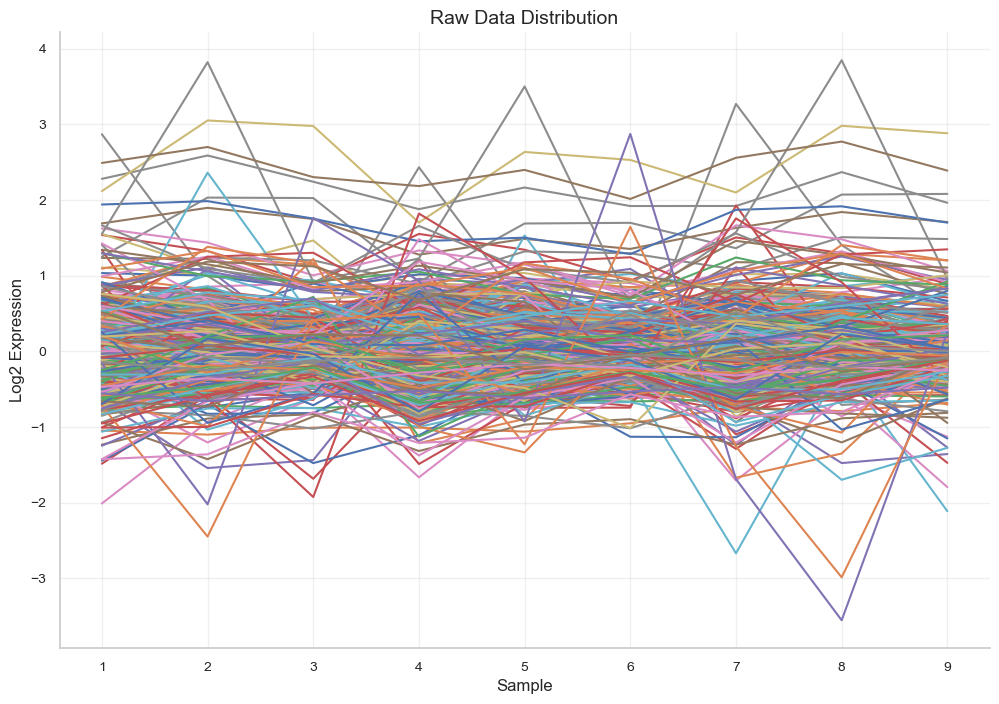

In [15]:
def load_and_explore_data(filepath):
    """Load and perform initial data exploration"""
    # Load data
    df = pd.read_csv(filepath)
    df = df.rename(columns={'Unnamed: 0': 'Ratio'})
    
    # Display basic information
    print("Dataset Shape:", df.shape)
    print("\nFirst few rows:")
    display(df.head())
    
    print("\nDataset Summary Statistics:")
    display(df.describe())
    
    return df

# Load dataset
df = load_and_explore_data(DATA_DIR / 'TMT_alldata_log2.csv')

# Visualise initial data distribution
plt.figure(figsize=(14, 6))
df_plot = df.set_index('Ratio').transpose()
df_plot.plot(legend=None)
plt.title('Raw Data Distribution')
plt.xlabel('Sample')
plt.ylabel('Log2 Expression')
plt.show()

## 4. Data Normalization

<Figure size 1400x600 with 0 Axes>

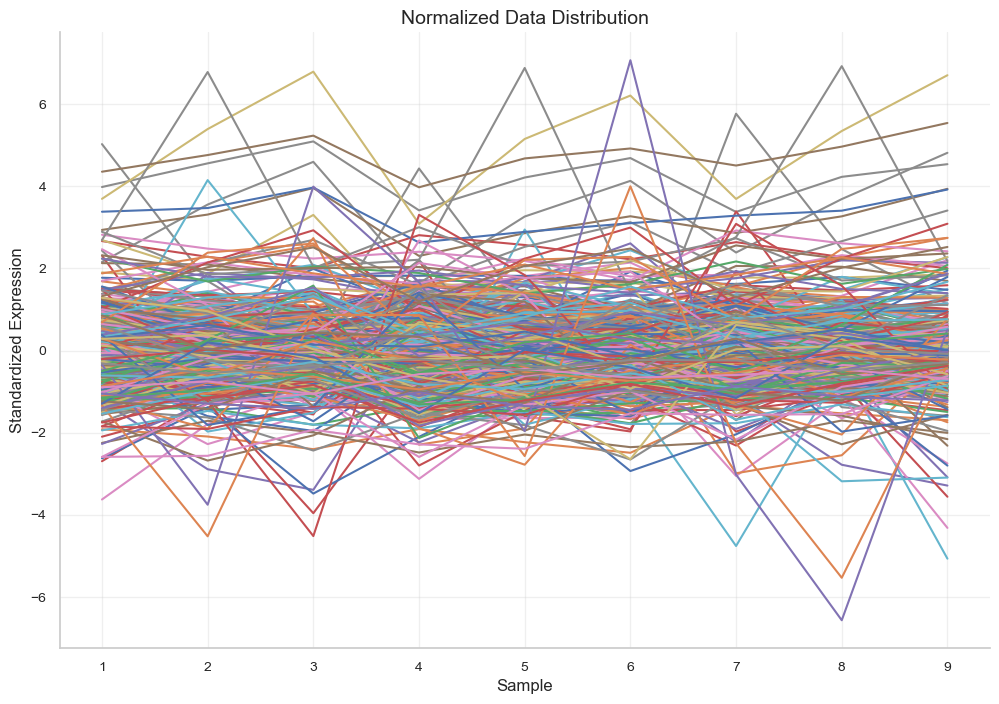

In [16]:
def normalize_data(df):
    """Normalize the dataset using StandardScaler"""
    # Separate features and protein names
    X = df.iloc[:, 1:].values
    proteins = df.iloc[:, 0].values
    
    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create normalized dataframe
    df_norm = pd.DataFrame(X_scaled, columns=df.columns[1:])
    df_norm.insert(0, 'Ratio', proteins)
    
    return df_norm

# Normalize data
df_norm = normalize_data(df)

# Visualise normalized distribution
plt.figure(figsize=(14, 6))
df_norm_plot = df_norm.set_index('Ratio').transpose()
df_norm_plot.plot(legend=None)
plt.title('Normalized Data Distribution')
plt.xlabel('Sample')
plt.ylabel('Standardized Expression')
plt.show()

## 5. Principal Component Analysis

Explained variance with 3 components: 91.59%

Explained variance ratio per component:
PC 1: 0.7148
PC 2: 0.1235
PC 3: 0.0776


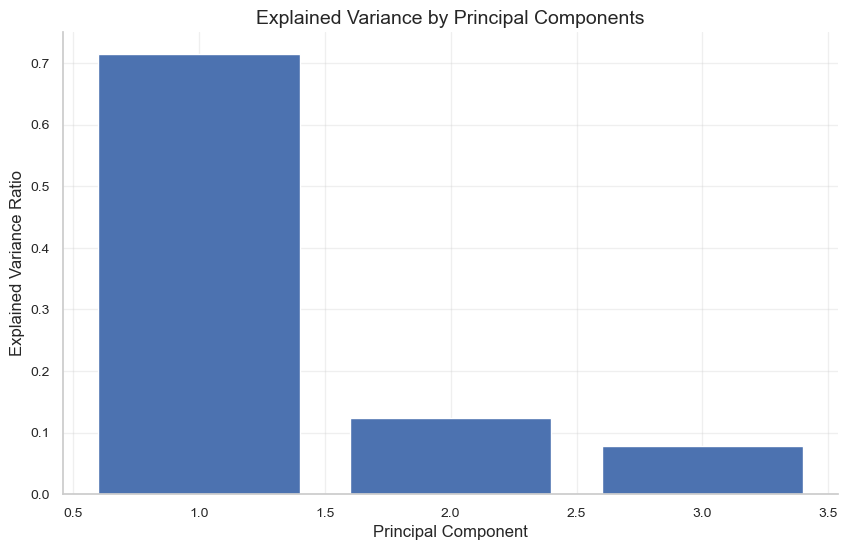

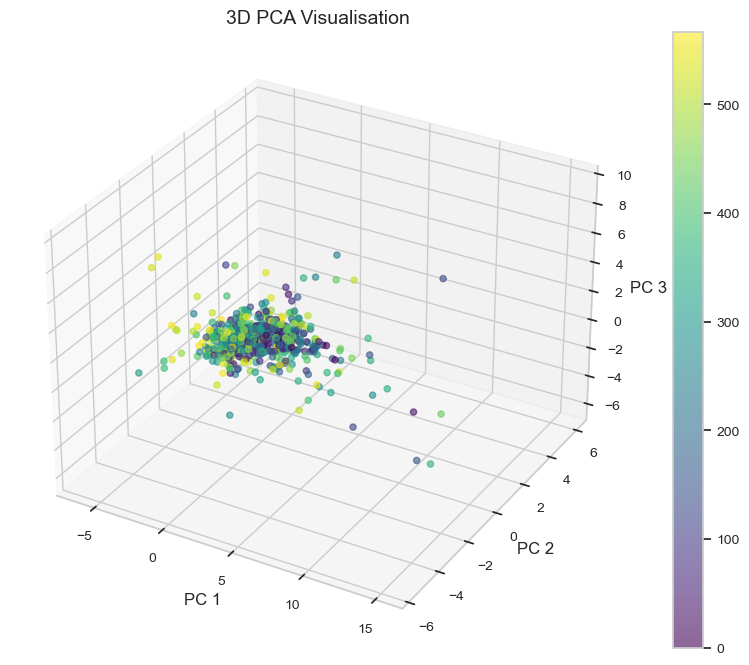

In [17]:
def perform_pca_analysis(df_norm, n_components=3):
    """Perform PCA and visualise results"""
    # Perform PCA
    pca = PCA(n_components=n_components)
    X = df_norm.iloc[:, 1:].values
    pca_result = pca.fit_transform(X)
    
    # Create PCA dataframe
    columns = [f'PC {i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=pca_result, columns=columns)
    pca_df['Ratio'] = df_norm['Ratio']
    
    # Calculate explained variance
    explained_var = np.sum(pca.explained_variance_ratio_) * 100
    print(f"Explained variance with {n_components} components: {explained_var:.2f}%")
    print("\nExplained variance ratio per component:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC {i+1}: {var:.4f}")
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.show()
    
    return pca_df, pca

# Perform PCA
pca_df, pca = perform_pca_analysis(df_norm)

# Visualise PCA results
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(pca_df['PC 1'], 
                      pca_df['PC 2'], 
                      pca_df['PC 3'],
                      c=range(len(pca_df)),
                      cmap='viridis',
                      alpha=0.6)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.colorbar(scatter)
plt.title('3D PCA Visualisation')
plt.show()

## 6. Determine Optimal Number of Clusters

k=1: SSE=4682.14
k=2: SSE=2739.88
k=3: SSE=1906.17
k=4: SSE=1582.04
k=5: SSE=1352.30
k=6: SSE=1197.47
k=7: SSE=1030.22
k=8: SSE=916.63
k=9: SSE=841.44
k=10: SSE=769.82
k=11: SSE=705.36
k=12: SSE=675.16
k=13: SSE=629.03
k=14: SSE=593.03
k=15: SSE=574.28


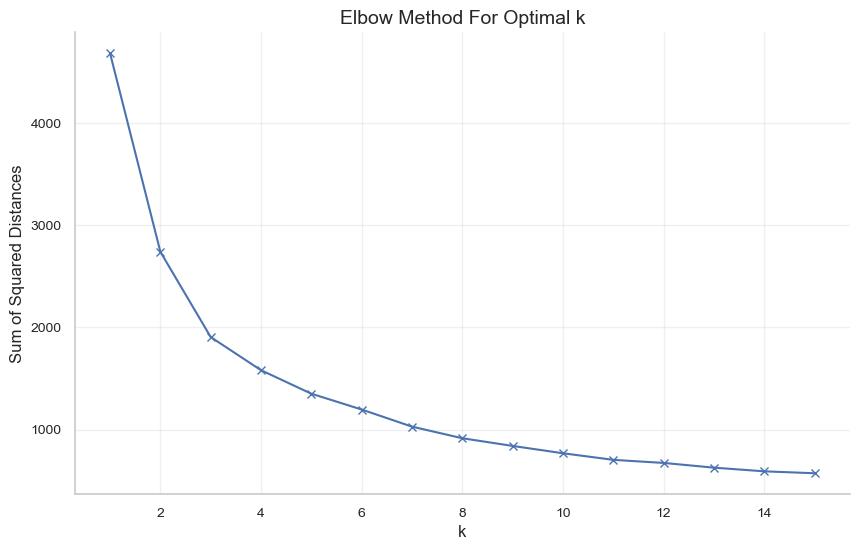

In [18]:
def plot_elbow_curve(X, max_clusters=15):
    """Plot elbow curve for optimal cluster selection"""
    inertias = []
    K = range(1, max_clusters + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        print(f"k={k}: SSE={kmeans.inertia_:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()
    
    return inertias

# Find optimal number of clusters
inertias = plot_elbow_curve(pca_df.iloc[:, :3])

## 7. K-means Clustering

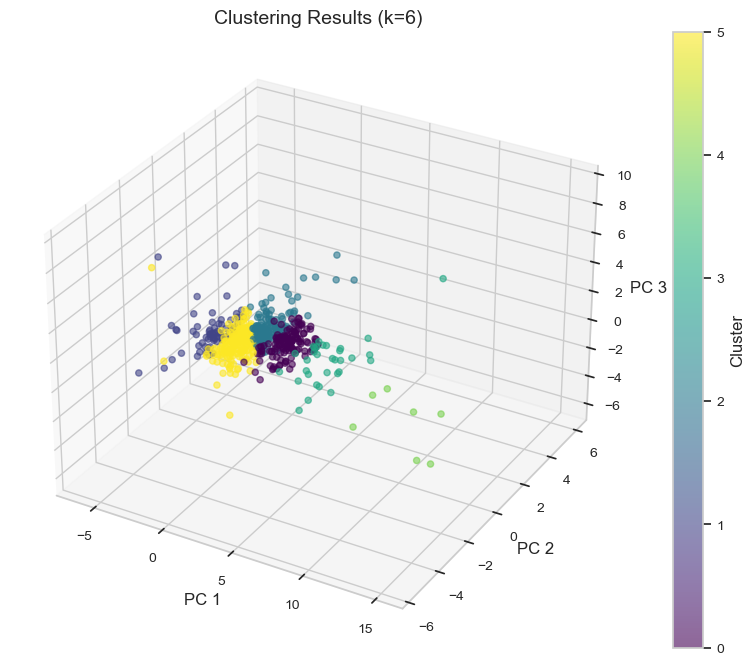

In [19]:
def perform_clustering(pca_df, n_clusters):
    """Perform k-means clustering and visualise results"""
    # Suppress specific sklearn warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=FutureWarning)
        
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        X = pca_df.iloc[:, :3]  # Use first 3 PCs
        labels = kmeans.fit_predict(X)
        
        # Add cluster labels to dataframe
        df_clustered = pca_df.copy()
        df_clustered['Cluster'] = labels
        
        # Plot clusters
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')
        scatter = ax.scatter3D(df_clustered['PC 1'],
                             df_clustered['PC 2'],
                             df_clustered['PC 3'],
                             c=df_clustered['Cluster'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Clustering Results (k={n_clusters})')
        plt.show()
        
        return df_clustered
    
    # Perform clustering with optimal k (example with k=6)
df_clustered = perform_clustering(pca_df, n_clusters=6)

## 8. Analyse CPNE3 Cluster

CPNE3 is in cluster 1
Number of proteins in CPNE3 cluster: 68

Proteins in CPNE3 cluster:


,PC 1,PC 2,PC 3,Ratio,Cluster
6,-2.515502,0.232341,0.479248,HIST2H2AC,1
23,-2.704981,0.978713,-0.050147,KRT8,1
114,-5.597949,2.612324,1.443001,LSM5,1
137,-2.691606,-0.293631,0.005120,RPL7,1
139,-3.035123,-0.898468,0.142932,RPL6,1
...,...,...,...,...,...
555,-2.733372,-0.913944,0.758506,SF3B2,1
556,-5.710713,-0.828126,0.165433,XRN2,1
562,-2.670845,-0.660642,-0.066693,POLR2B,1
563,-3.373966,-1.089919,-0.368454,GEMIN4,1


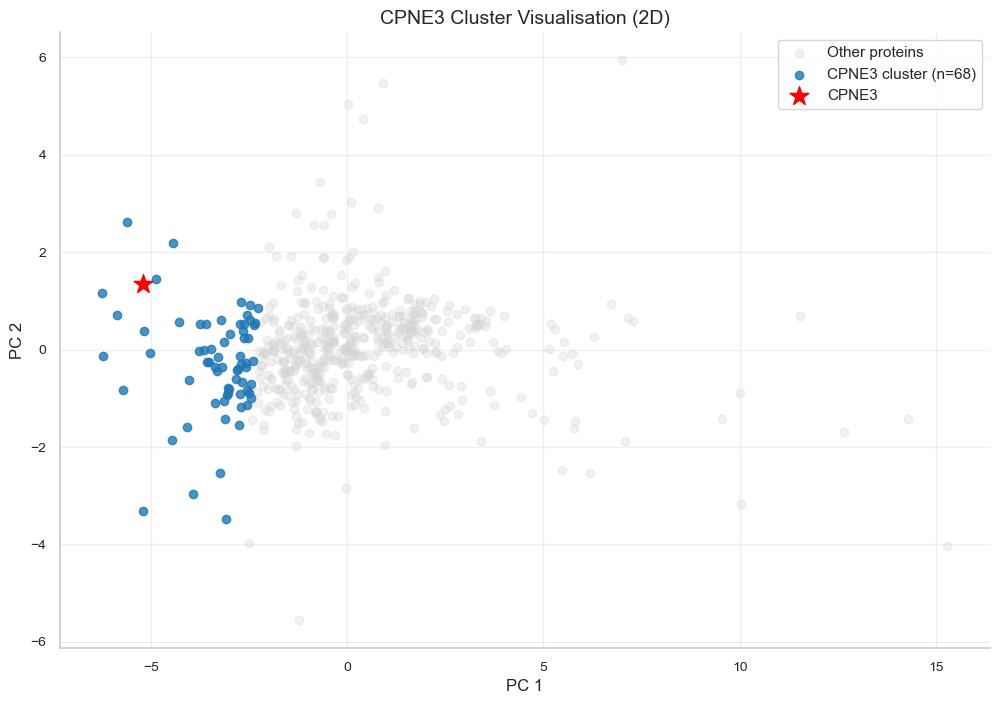

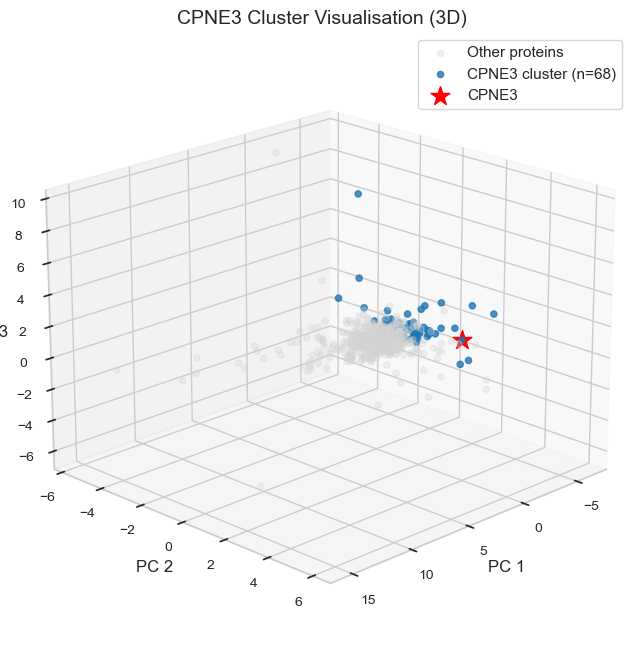

In [20]:
def analyse_cpne3_cluster(df_clustered):
    """Analyse proteins clustering with CPNE3"""
    # Find CPNE3 cluster
    cpne3_cluster = df_clustered[df_clustered['Ratio'] == 'CPNE3']['Cluster'].iloc[0]
    cluster_proteins = df_clustered[df_clustered['Cluster'] == cpne3_cluster]
    
    print(f"CPNE3 is in cluster {cpne3_cluster}")
    print(f"Number of proteins in CPNE3 cluster: {len(cluster_proteins)}")
    
    # Display proteins in CPNE3 cluster
    print("\nProteins in CPNE3 cluster:")
    display(cluster_proteins)
    
    # Create 2D visualisation
    plt.figure(figsize=(12, 8))
    
    # Plot non-CPNE3 clusters in grey
    mask_other = df_clustered['Cluster'] != cpne3_cluster
    plt.scatter(df_clustered.loc[mask_other, 'PC 1'],
                df_clustered.loc[mask_other, 'PC 2'],
                c='lightgrey',
                alpha=0.3,
                label='Other proteins')
    
    # Plot CPNE3 cluster in blue
    mask_cpne3 = df_clustered['Cluster'] == cpne3_cluster
    plt.scatter(df_clustered.loc[mask_cpne3, 'PC 1'],
                df_clustered.loc[mask_cpne3, 'PC 2'],
                c='#1f77b4',
                alpha=0.8,
                label=f'CPNE3 cluster (n={len(cluster_proteins)})')
    
    # Highlight CPNE3 itself
    cpne3_point = df_clustered[df_clustered['Ratio'] == 'CPNE3']
    plt.scatter(cpne3_point['PC 1'],
                cpne3_point['PC 2'],
                c='red',
                marker='*',
                s=200,
                label='CPNE3')
    
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('CPNE3 Cluster Visualisation (2D)')
    plt.legend()
    plt.show()
    
    # Create 3D visualisation
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot non-CPNE3 clusters in grey
    ax.scatter(df_clustered.loc[mask_other, 'PC 1'],
               df_clustered.loc[mask_other, 'PC 2'],
               df_clustered.loc[mask_other, 'PC 3'],
               c='lightgrey',
               alpha=0.3,
               label='Other proteins')
    
    # Plot CPNE3 cluster in blue
    ax.scatter(df_clustered.loc[mask_cpne3, 'PC 1'],
               df_clustered.loc[mask_cpne3, 'PC 2'],
               df_clustered.loc[mask_cpne3, 'PC 3'],
               c='#1f77b4',
               alpha=0.8,
               label=f'CPNE3 cluster (n={len(cluster_proteins)})')
    
    # Highlight CPNE3 itself
    ax.scatter(cpne3_point['PC 1'],
               cpne3_point['PC 2'],
               cpne3_point['PC 3'],
               c='red',
               marker='*',
               s=200,
               label='CPNE3')
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    plt.title('CPNE3 Cluster Visualisation (3D)')
    plt.legend()
    
    # Add rotation for better visualisation
    ax.view_init(elev=20, azim=45)
    plt.show()
    
    return cluster_proteins


# Analyse CPNE3 cluster
cpne3_cluster = analyse_cpne3_cluster(df_clustered)

## 9. Save Results

In [21]:
# Save clustered results
df_clustered.to_csv(RESULTS_DIR / 'TMT_clustering_results.csv', index=False)
print("Results saved to 'results/TMT_clustering_results.csv'")

Results saved to 'results/TMT_clustering_results.csv'


The notebook provides a comprehensive analysis of the TMT LC-MS/MS data with clear visualisation and documentation at each step. Each section is focused on a specific aspect of the analysis, making it easy to follow and modify as needed.